In [ ]:
#!pip install face-alignment opencv-python scikit-image lpips pytorch-fid
#!pip install kornia timm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet50

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import random
import os
from tqdm import tqdm
import json

from pytorch_fid.fid_score import calculate_fid_given_paths
from pytorch_fid import fid_score

import lpips

from skimage.metrics import structural_similarity as ssim

import tempfile
from skimage.metrics import peak_signal_noise_ratio as psnr

from google.colab import drive
drive.mount('/content/drive')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU only'}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
GPU: Tesla T4


# 간단한 데이터 생성

In [ ]:
class SimpleFaceMaskDataset(Dataset):
    def __init__(self, num_samples=1000, img_size=256, mode='train'):
        self.num_samples = num_samples
        self.img_size = img_size
        self.mode = mode

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        self.data = self._generate_data()

    def _generate_simple_face(self):
        """간단한 합성 얼굴 생성"""
        img = np.ones((self.img_size, self.img_size, 3), dtype=np.uint8) * 220

        center_x, center_y = self.img_size // 2, self.img_size // 2
        axes_x, axes_y = self.img_size // 3, self.img_size // 2.5

        skin_color = np.random.randint(180, 240, 3)

        img_pil = Image.fromarray(img)
        draw = ImageDraw.Draw(img_pil)

        draw.ellipse([center_x - axes_x, center_y - axes_y,
                     center_x + axes_x, center_y + axes_y],
                    fill=tuple(skin_color.astype(int)))

        eye_y = center_y - 30
        draw.ellipse([center_x - 50, eye_y - 10, center_x - 30, eye_y + 10], fill=(0, 0, 0))
        draw.ellipse([center_x + 30, eye_y - 10, center_x + 50, eye_y + 10], fill=(0, 0, 0))

        draw.ellipse([center_x - 5, center_y, center_x + 5, center_y + 15], fill=(100, 100, 100))

        mouth_y = center_y + 30
        draw.ellipse([center_x - 25, mouth_y - 5, center_x + 25, mouth_y + 10], fill=(200, 100, 100))

        return np.array(img_pil)

    def _generate_mask(self):
        """간단한 마스크 생성"""
        mask = np.zeros((self.img_size, self.img_size), dtype=np.uint8)

        mask_type = np.random.choice(['surgical', 'n95', 'cloth'])

        center_x, center_y = self.img_size // 2, self.img_size // 2 + 20

        if mask_type == 'surgical':
            w, h = 80, 60
            mask[center_y - h//2:center_y + h//2, center_x - w//2:center_x + w//2] = 255
        elif mask_type == 'n95':
            mask_pil = Image.fromarray(mask)
            draw = ImageDraw.Draw(mask_pil)
            draw.ellipse([center_x - 60, center_y - 40, center_x + 60, center_y + 30], fill=255)
            mask = np.array(mask_pil)
        else:
            mask_pil = Image.fromarray(mask)
            draw = ImageDraw.Draw(mask_pil)
            points = [(center_x - 70, center_y - 30), (center_x + 70, center_y - 30),
                     (center_x + 60, center_y + 40), (center_x - 60, center_y + 40)]
            draw.polygon(points, fill=255)
            mask = np.array(mask_pil)

        return mask

    def _generate_data(self):
        data = []
        for i in tqdm(range(self.num_samples), desc=f"Generating {self.mode} data"):
            face = self._generate_simple_face()


            mask = self._generate_mask()

            masked_face = face.copy()
            mask_3d = np.stack([mask, mask, mask], axis=2) / 255.0
            masked_face = (masked_face * (1 - mask_3d) +
                          np.ones_like(face) * 128 * mask_3d).astype(np.uint8)

            data.append({
                'original': face,
                'masked': masked_face,
                'mask': mask
            })

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        original = self.transform(item['original'])
        masked = self.transform(item['masked'])
        mask = torch.from_numpy(item['mask']).float() / 255.0

        return {
            'original': original,
            'masked': masked,
            'mask': mask,
            'mask_binary': (mask > 0.5).float()
        }


print("Creating datasets...")
train_dataset = SimpleFaceMaskDataset(num_samples=800, mode='train')
test_dataset = SimpleFaceMaskDataset(num_samples=200, mode='test')


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

print(f"Train dataset: {len(train_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")


sample = train_dataset[0]
print(f"Sample shapes - Original: {sample['original'].shape}, Masked: {sample['masked'].shape}, Mask: {sample['mask'].shape}")

Creating datasets...


Generating test data: 100%|██████████| 200/200 [00:00<00:00, 479.47it/s]

Train dataset: 800 samples
Test dataset: 200 samples
Sample shapes - Original: torch.Size([3, 256, 256]), Masked: torch.Size([3, 256, 256]), Mask: torch.Size([256, 256])


 Dataset Visualization


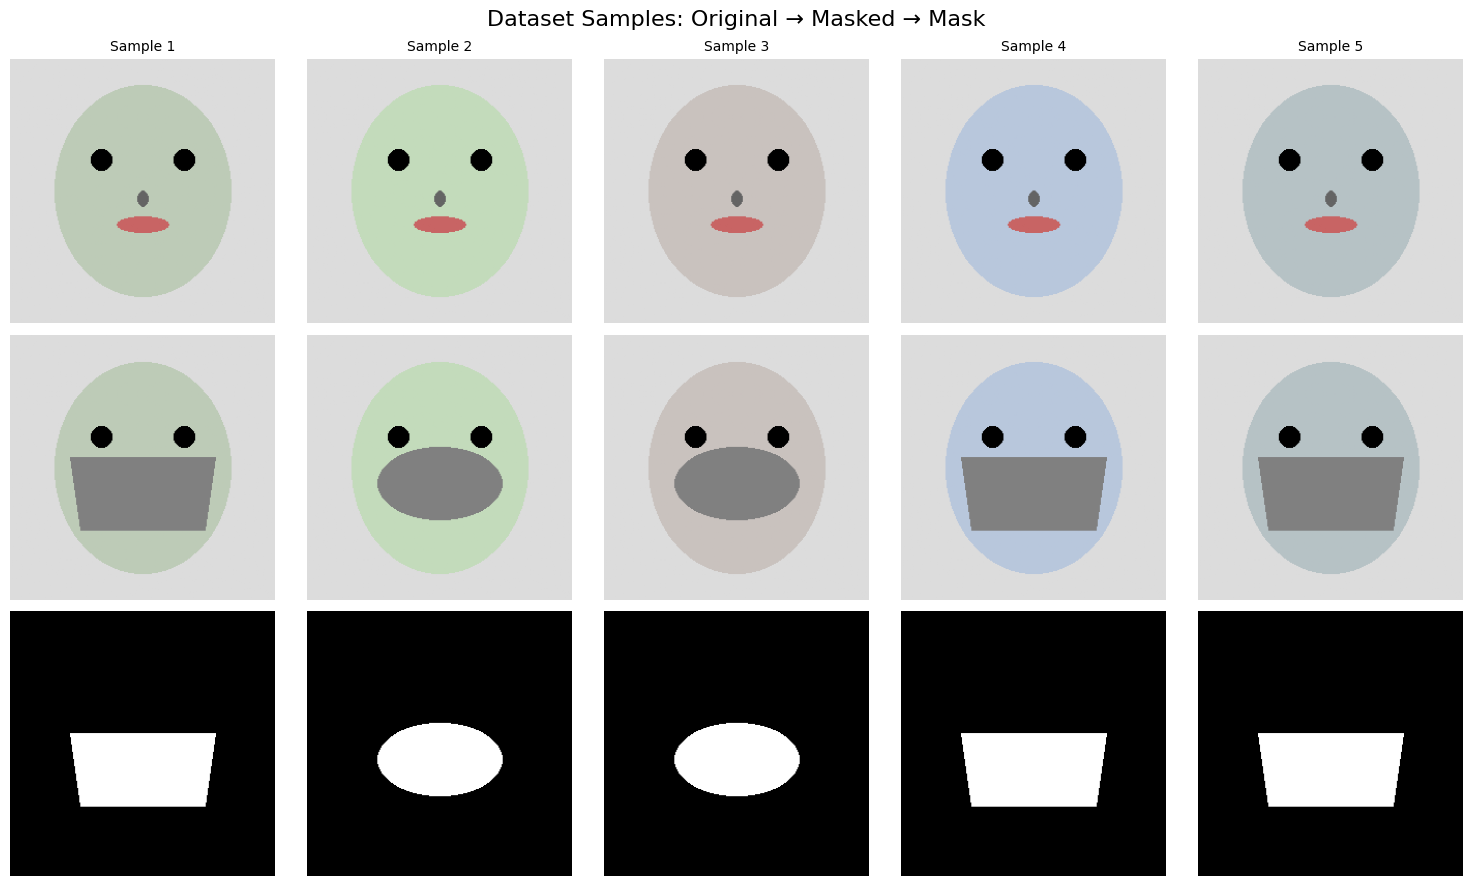

Analyzing mask types...
Mask type distribution (out of 50 samples):
  Surgical: 34 (68.0%)
  N95: 0 (0.0%)
  Cloth: 16 (32.0%)

----------------------------------------
 Detailed Sample Analysis
----------------------------------------


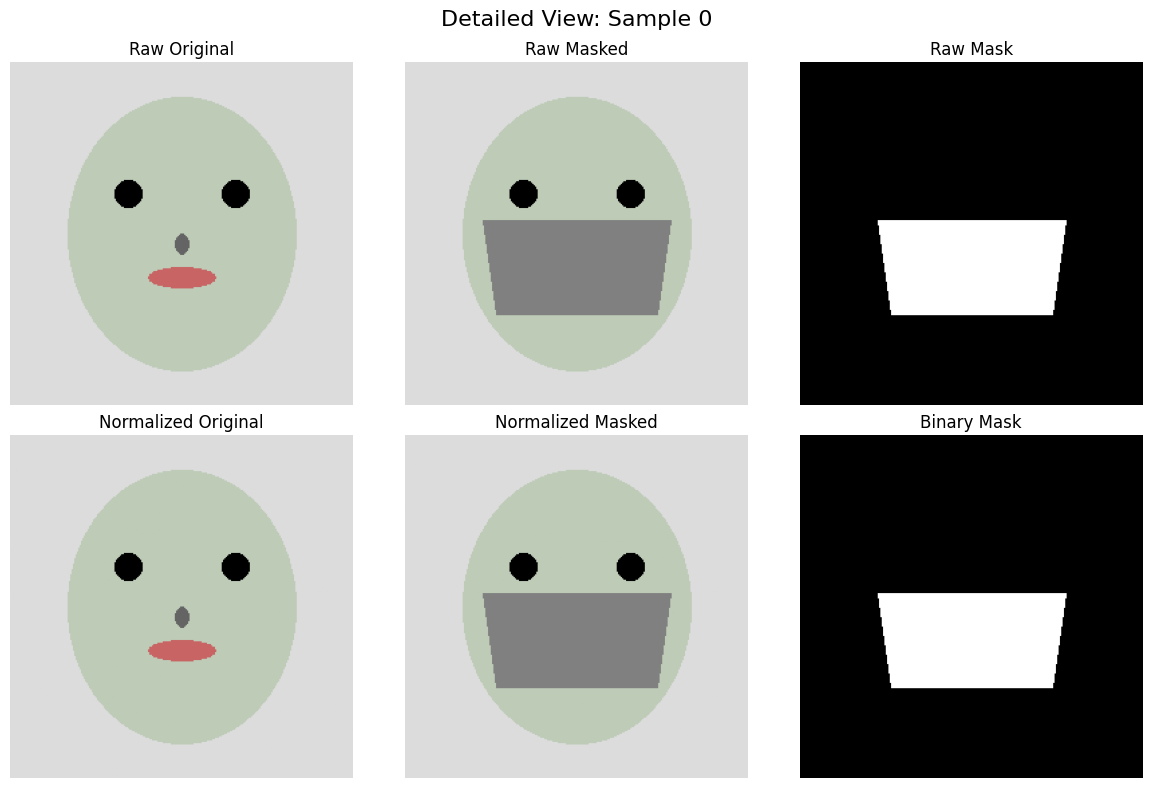

Sample 0 Statistics:
  Original tensor shape: torch.Size([3, 256, 256])
  Original tensor range: [-1.000, 0.725]
  Mask tensor shape: torch.Size([256, 256])
  Mask coverage: 14.2%


In [ ]:
def visualize_dataset_samples(dataset, num_samples=5):
    """데이터셋에서 샘플들을 시각화"""

    fig, axes = plt.subplots(3, num_samples, figsize=(15, 9))
    fig.suptitle('Dataset Samples: Original → Masked → Mask', fontsize=16)

    row_titles = ['Original Face', 'Masked Face', 'Binary Mask']
    for i, title in enumerate(row_titles):
        axes[i, 0].set_ylabel(title, fontsize=12, rotation=90, labelpad=20)

    for i in range(num_samples):
        sample = dataset[i]

        original_img = ((sample['original'] + 1) / 2).permute(1, 2, 0).numpy()
        masked_img = ((sample['masked'] + 1) / 2).permute(1, 2, 0).numpy()
        mask_img = sample['mask_binary'].numpy()

        original_img = np.clip(original_img, 0, 1)
        masked_img = np.clip(masked_img, 0, 1)

        axes[0, i].imshow(original_img)
        axes[0, i].set_title(f'Sample {i+1}', fontsize=10)
        axes[0, i].axis('off')


        axes[1, i].imshow(masked_img)
        axes[1, i].axis('off')

        axes[2, i].imshow(mask_img, cmap='gray')
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()

def show_mask_types_distribution(dataset, num_check=50):
    """마스크 타입 분포 확인"""
    mask_types = {'surgical': 0, 'n95': 0, 'cloth': 0}

    print("Analyzing mask types...")
    for i in range(min(num_check, len(dataset))):
        sample = dataset[i]
        mask = sample['mask_binary'].numpy()

        mask_area = np.sum(mask > 0.5)
        mask_height = np.sum(np.any(mask > 0.5, axis=1))
        mask_width = np.sum(np.any(mask > 0.5, axis=0))

        aspect_ratio = mask_width / max(mask_height, 1)

        if aspect_ratio < 1.3:
            mask_types['n95'] += 1
        elif aspect_ratio > 1.6:
            mask_types['surgical'] += 1
        else:
            mask_types['cloth'] += 1

    print(f"Mask type distribution (out of {num_check} samples):")
    for mask_type, count in mask_types.items():
        percentage = (count / num_check) * 100
        print(f"  {mask_type.capitalize()}: {count} ({percentage:.1f}%)")

def show_detailed_sample(dataset, sample_idx=0):
    """특정 샘플의 상세 정보 표시"""
    sample = dataset[sample_idx]

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle(f'Detailed View: Sample {sample_idx}', fontsize=16)

    original_raw = dataset.data[sample_idx]['original']
    masked_raw = dataset.data[sample_idx]['masked']
    mask_raw = dataset.data[sample_idx]['mask']

    original_norm = ((sample['original'] + 1) / 2).permute(1, 2, 0).numpy()
    masked_norm = ((sample['masked'] + 1) / 2).permute(1, 2, 0).numpy()
    mask_binary = sample['mask_binary'].numpy()

    axes[0, 0].imshow(original_raw)
    axes[0, 0].set_title('Raw Original')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(masked_raw)
    axes[0, 1].set_title('Raw Masked')
    axes[0, 1].axis('off')

    axes[0, 2].imshow(mask_raw, cmap='gray')
    axes[0, 2].set_title('Raw Mask')
    axes[0, 2].axis('off')

    axes[1, 0].imshow(np.clip(original_norm, 0, 1))
    axes[1, 0].set_title('Normalized Original')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(np.clip(masked_norm, 0, 1))
    axes[1, 1].set_title('Normalized Masked')
    axes[1, 1].axis('off')

    axes[1, 2].imshow(mask_binary, cmap='gray')
    axes[1, 2].set_title('Binary Mask')
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Sample {sample_idx} Statistics:")
    print(f"  Original tensor shape: {sample['original'].shape}")
    print(f"  Original tensor range: [{sample['original'].min():.3f}, {sample['original'].max():.3f}]")
    print(f"  Mask tensor shape: {sample['mask'].shape}")
    print(f"  Mask coverage: {sample['mask_binary'].sum().item() / (256*256) * 100:.1f}%")

print("=" * 60)
print(" Dataset Visualization")
print("=" * 60)

visualize_dataset_samples(train_dataset, num_samples=5)

show_mask_types_distribution(train_dataset, num_check=50)

print(f"\n{'-'*40}")
print(" Detailed Sample Analysis")
print(f"{'-'*40}")
show_detailed_sample(train_dataset, sample_idx=0)

#N3D 모듈: 3D Reconstruction + Mask Segmentation

In [ ]:
class GatedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(GatedConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels * 2, kernel_size, stride, padding)

    def forward(self, x):
        x = self.conv(x)
        out, gate = x.chunk(2, dim=1)
        return out * torch.sigmoid(gate)

class N3D_Module(nn.Module):
    def __init__(self, pretrained=True):
        super(N3D_Module, self).__init__()

        resnet = resnet50(pretrained=pretrained)
        self.backbone = nn.ModuleList([
            nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool),
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4
        ])

        self.mask_head = nn.Sequential(
            nn.Conv2d(256 + 512 + 1024, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 1, 1),
            nn.Sigmoid()
        )

        self.gated_conv = GatedConv2d(1024, 1024, 3, 1, 1)

        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 237)
        )

    def forward(self, x):
      batch_size = x.size(0)
      features = []

      out = x
      for i, layer in enumerate(self.backbone):
          out = layer(out)
          features.append(out)

      f1 = F.interpolate(features[1], size=features[0].shape[2:], mode='bilinear', align_corners=False)
      f2 = F.interpolate(features[2], size=features[0].shape[2:], mode='bilinear', align_corners=False)
      f3 = F.interpolate(features[3], size=features[0].shape[2:], mode='bilinear', align_corners=False)

      mask_features = torch.cat([f1, f2, f3], dim=1)
      mask_pred = self.mask_head(mask_features)
      mask_pred = F.interpolate(mask_pred, size=(x.size(2), x.size(3)), mode='bilinear', align_corners=False)

      gated_features = self.gated_conv(features[3])

      if gated_features.size(1) != features[4].size(1):
          combined_features = features[4]
      else:
          combined_features = torch.cat([gated_features, features[4]], dim=1)

      coeffs_pred = self.fc(combined_features)

      return mask_pred, coeffs_pred

def simple_3d_render(coeffs, img_size=256):
    """
    간단한 3D 얼굴 렌더링 시뮬레이션
    실제로는 3DMM 기반 렌더러가 필요하지만, 여기서는 간단히 구현
    """
    batch_size = coeffs.size(0)
    rendered = torch.zeros((batch_size, 3, img_size, img_size), device=coeffs.device)

    for b in range(batch_size):
        center_x, center_y = img_size // 2, img_size // 2

        shape_params = coeffs[b, :80]
        texture_params = coeffs[b, 80:160]
        pose_params = coeffs[b, 160:172]

        face_color = 0.8 + 0.2 * torch.tanh(texture_params[:3]).mean()
        face_size = 80 + 20 * torch.tanh(shape_params[:5]).mean()

        y, x = torch.meshgrid(torch.arange(img_size), torch.arange(img_size), indexing='ij')
        y, x = y.float().to(coeffs.device), x.float().to(coeffs.device)

        face_mask = ((x - center_x) / face_size) ** 2 + ((y - center_y) / (face_size * 1.2)) ** 2 < 1

        rendered[b, :, face_mask] = face_color

    return rendered

# 인페인팅 모듈: Generator + Discriminator

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return F.relu(out + residual)

class InpaintingGenerator(nn.Module):
    def __init__(self, input_channels=7):
        super(InpaintingGenerator, self).__init__()

        self.encoder = nn.ModuleList([
            nn.Sequential(nn.Conv2d(input_channels, 64, 7, 1, 3), nn.BatchNorm2d(64), nn.ReLU(inplace=True)),
            nn.Sequential(nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(inplace=True)),
            nn.Sequential(nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(inplace=True)),
            nn.Sequential(nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU(inplace=True)),
        ])

        self.res_blocks = nn.ModuleList([ResBlock(512) for _ in range(6)])

        self.decoder = nn.ModuleList([
            nn.Sequential(nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(inplace=True)),
            nn.Sequential(nn.ConvTranspose2d(512, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(inplace=True)),
            nn.Sequential(nn.ConvTranspose2d(256, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(inplace=True)),
            nn.Sequential(nn.Conv2d(128, 3, 7, 1, 3), nn.Tanh())
        ])

    def forward(self, masked_img, mask, rendered_3d):
      mask_expanded = mask.unsqueeze(1) if len(mask.shape) == 3 else mask
      x = torch.cat([masked_img, mask_expanded, rendered_3d], dim=1)

      skip_connections = []
      for i, encoder_layer in enumerate(self.encoder):
          x = encoder_layer(x)
          skip_connections.append(x)

      for res_block in self.res_blocks:
          x = res_block(x)

      for i, decoder_layer in enumerate(self.decoder):

          if i == 0:
              x = decoder_layer(x)
          elif i < len(self.decoder) - 1:
              skip = skip_connections[len(skip_connections) - i - 1]
              x = torch.cat([x, skip], dim=1)
              x = decoder_layer(x)
          else:
              skip = skip_connections[0]
              x = torch.cat([x, skip], dim=1)
              x = decoder_layer(x)


      return x

class PatchDiscriminator(nn.Module):
    def __init__(self, input_channels=3):
        super(PatchDiscriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(input_channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

class SimpleArcFace(nn.Module):
    def __init__(self):
        super(SimpleArcFace, self).__init__()
        resnet = resnet50(pretrained=True)
        self.backbone = nn.Sequential(
            *list(resnet.children())[:-1]
        )
        self.fc = nn.Linear(2048, 512)

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.normalize(x, p=2, dim=1)

n3d_model = N3D_Module(pretrained=True).to(device)
generator = InpaintingGenerator().to(device)
discriminator = PatchDiscriminator().to(device)
arcface = SimpleArcFace().to(device)

print("Models initialized successfully!")
print(f"N3D parameters: {sum(p.numel() for p in n3d_model.parameters()):,}")
print(f"Generator parameters: {sum(p.numel() for p in generator.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in discriminator.parameters()):,}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Models initialized successfully!
N3D parameters: 54,165,294
Generator parameters: 34,535,363
Discriminator parameters: 6,962,369


# 손실 함수

In [ ]:
class LossFunctions:
    def __init__(self, device):
        self.device = device
        self.lpips_loss = lpips.LPIPS(net='vgg').to(device)

    def bce_loss(self, pred_mask, gt_mask):
        """이진 크로스 엔트로피 손실 (Equation 1)"""
        return F.binary_cross_entropy(pred_mask, gt_mask)

    def coefficient_loss(self, pred_coeffs, gt_coeffs):
        """계수 손실 (Equation 2)"""
        return F.l1_loss(pred_coeffs, gt_coeffs)

    def photo_loss(self, rendered_3d, original_img, face_mask=None):
        """포토 손실 (Equation 3)"""
        if face_mask is not None:
            face_mask = face_mask.unsqueeze(1).expand_as(rendered_3d)
            return F.mse_loss(rendered_3d * face_mask, original_img * face_mask)
        else:
            return F.mse_loss(rendered_3d, original_img)

    def identity_loss(self, img1, img2, arcface_model):
        """아이덴티티 손실 (Equation 4)"""
        feat1 = arcface_model(img1)
        feat2 = arcface_model(img2)

        cosine_sim = F.cosine_similarity(feat1, feat2, dim=1)
        return 1 - cosine_sim.mean()

    def landmark_loss(self, pred_landmarks, gt_landmarks, weights=None):
        """랜드마크 손실 (Equation 5)"""
        if weights is not None:
            weighted_diff = weights * F.mse_loss(pred_landmarks, gt_landmarks, reduction='none')
            return weighted_diff.mean()
        else:
            return F.mse_loss(pred_landmarks, gt_landmarks)

    def pixel_loss(self, pred_img, gt_img):
        """픽셀 손실 (Equation 7)"""
        return F.l1_loss(pred_img, gt_img)

    def total_variation_loss(self, img):
        """총 변동 손실 (Equation 8)"""
        batch_size, channels, h, w = img.size()

        h_tv = F.mse_loss(img[:, :, 1:, :], img[:, :, :-1, :])
        w_tv = F.mse_loss(img[:, :, :, 1:], img[:, :, :, :-1])

        return h_tv + w_tv

    def adversarial_loss_generator(self, fake_pred):
        """생성자용 적대 손실 (Equation 9)"""
        return -torch.log(fake_pred + 1e-8).mean()

    def adversarial_loss_discriminator(self, real_pred, fake_pred):
        """판별자용 적대 손실 (Equation 11)"""
        real_loss = -torch.log(real_pred + 1e-8).mean()
        fake_loss = -torch.log(1 - fake_pred + 1e-8).mean()
        return real_loss + fake_loss

    def gradient_penalty(self, discriminator, real_imgs, fake_imgs):
        """그래디언트 패널티"""
        batch_size = real_imgs.size(0)

        alpha = torch.rand(batch_size, 1, 1, 1).to(self.device)
        interpolated = alpha * real_imgs + (1 - alpha) * fake_imgs
        interpolated.requires_grad_(True)

        d_interpolated = discriminator(interpolated)

        gradients = torch.autograd.grad(
            outputs=d_interpolated,
            inputs=interpolated,
            grad_outputs=torch.ones_like(d_interpolated),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]

        gradients = gradients.view(batch_size, -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

        return gradient_penalty

    def compute_n3d_loss(self, pred_mask, gt_mask, pred_coeffs, gt_coeffs,
                        rendered_3d, original_img, arcface_model,
                        pred_landmarks=None, gt_landmarks=None):
        """N3D 모듈의 총 손실 (Equation 6)"""

        l_bce = self.bce_loss(pred_mask, gt_mask)
        l_coef = self.coefficient_loss(pred_coeffs, gt_coeffs)
        l_photo = self.photo_loss(rendered_3d, original_img)
        l_id = self.identity_loss(rendered_3d, original_img, arcface_model)

        if pred_landmarks is not None and gt_landmarks is not None:
            weights = torch.ones(68).to(self.device)
            nose_indices = list(range(30, 36))
            inner_mouth_indices = list(range(60, 68))
            weights[nose_indices] = 20
            weights[inner_mouth_indices] = 20

            l_lm = self.landmark_loss(pred_landmarks, gt_landmarks, weights)
        else:
            l_lm = torch.tensor(0.0).to(self.device)

        lambda_id = 0.1
        lambda_lm = 0.001

        total_loss = l_bce + l_coef + l_photo + lambda_id * l_id + lambda_lm * l_lm

        return total_loss, {
            'bce': l_bce.item(),
            'coef': l_coef.item(),
            'photo': l_photo.item(),
            'id': l_id.item(),
            'lm': l_lm.item() if isinstance(l_lm, torch.Tensor) else 0.0
        }

    def compute_generator_loss(self, pred_img, gt_img, fake_pred, arcface_model):
        """생성자 총 손실 (Equation 10)"""

        l_pix = self.pixel_loss(pred_img, gt_img)
        l_id = self.identity_loss(pred_img, gt_img, arcface_model)
        l_tv = self.total_variation_loss(pred_img)
        l_adv = self.adversarial_loss_generator(fake_pred)

        lambda_pix = 10
        lambda_id = 0.1
        lambda_tv = 0.1
        lambda_adv = 0.01

        total_loss = (lambda_pix * l_pix + lambda_id * l_id +
                     lambda_tv * l_tv + lambda_adv * l_adv)

        return total_loss, {
            'pix': l_pix.item(),
            'id': l_id.item(),
            'tv': l_tv.item(),
            'adv': l_adv.item()
        }

    def compute_discriminator_loss(self, real_pred, fake_pred,
                                  real_imgs, fake_imgs, discriminator):
        """판별자 총 손실 (Equation 11)"""

        l_adv = self.adversarial_loss_discriminator(real_pred, fake_pred)

        l_gp = self.gradient_penalty(discriminator, real_imgs, fake_imgs.detach())

        total_loss = l_adv + l_gp

        return total_loss, {
            'adv': l_adv.item(),
            'gp': l_gp.item()
        }

loss_fn = LossFunctions(device)
print("Loss functions initialized!")

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth
Loss functions initialized!


# 훈련 루프

In [ ]:
def add_noise_to_masked_region(masked_img, mask):
    """마스크 영역에 노이즈 추가"""
    noise = torch.randn_like(masked_img) * 0.1
    mask_3d = mask.unsqueeze(1).expand_as(masked_img)
    noisy_img = masked_img * (1 - mask_3d) + noise * mask_3d
    return noisy_img

def train_n3d_phase(n3d_model, train_loader, optimizer, loss_fn, arcface_model,
                    num_steps=500000, save_interval=50000):
    """N3D 모듈 훈련 (첫 번째 단계)"""

    n3d_model.train()
    step = 0
    losses_history = []

    print("Starting N3D training phase...")

    while step < num_steps:
        for batch in train_loader:
            if step >= num_steps:
                break

            original = batch['original'].to(device)
            masked = batch['masked'].to(device)
            mask_gt = batch['mask_binary'].to(device)

            gt_coeffs = torch.randn(original.size(0), 237).to(device)

            pred_mask, pred_coeffs = n3d_model(masked)

            rendered_3d = simple_3d_render(pred_coeffs, img_size=256)

            total_loss, loss_dict = loss_fn.compute_n3d_loss(
                pred_mask.squeeze(1), mask_gt, pred_coeffs, gt_coeffs,
                rendered_3d, original, arcface_model
            )

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            if step % 1000 == 0:
                print(f"N3D Step {step}/{num_steps}, Total Loss: {total_loss.item():.4f}")
                print(f"  BCE: {loss_dict['bce']:.4f}, Coef: {loss_dict['coef']:.4f}, "
                      f"Photo: {loss_dict['photo']:.4f}, ID: {loss_dict['id']:.4f}")

            losses_history.append(total_loss.item())
            step += 1

            if step == num_steps // 2:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 1e-5
                print("Learning rate reduced to 1e-5")

            if step % save_interval == 0:
                torch.save(n3d_model.state_dict(), f'/content/n3d_model_step_{step}.pth')

    return losses_history

def train_inpainting_phase(n3d_model, generator, discriminator, train_loader,
                          optimizer_g, optimizer_d, loss_fn, arcface_model,
                          num_steps=200000, save_interval=20000):
    """인페인팅 모듈 훈련 (두 번째 단계)"""

    n3d_model.eval()
    generator.train()
    discriminator.train()

    step = 0
    g_losses_history = []
    d_losses_history = []

    print("Starting Inpainting training phase...")

    while step < num_steps:
        for batch in train_loader:
            if step >= num_steps:
                break

            original = batch['original'].to(device)
            masked = batch['masked'].to(device)
            mask_gt = batch['mask_binary'].to(device)

            with torch.no_grad():
                pred_mask, pred_coeffs = n3d_model(masked)
                rendered_3d = simple_3d_render(pred_coeffs, img_size=256)

            noisy_masked = add_noise_to_masked_region(masked, pred_mask.squeeze(1))

            optimizer_g.zero_grad()

            fake_img = generator(noisy_masked, pred_mask.squeeze(1), rendered_3d)
            fake_pred = discriminator(fake_img)

            g_loss, g_loss_dict = loss_fn.compute_generator_loss(
                fake_img, original, fake_pred, arcface_model
            )

            g_loss.backward()
            optimizer_g.step()

            optimizer_d.zero_grad()

            real_pred = discriminator(original)
            fake_pred = discriminator(fake_img.detach())

            d_loss, d_loss_dict = loss_fn.compute_discriminator_loss(
                real_pred, fake_pred, original, fake_img, discriminator
            )

            d_loss.backward()
            optimizer_d.step()

            if step % 1000 == 0:
                print(f"Inpainting Step {step}/{num_steps}")
                print(f"  G_Loss: {g_loss.item():.4f} (Pix: {g_loss_dict['pix']:.4f}, "
                      f"ID: {g_loss_dict['id']:.4f}, TV: {g_loss_dict['tv']:.4f}, "
                      f"Adv: {g_loss_dict['adv']:.4f})")
                print(f"  D_Loss: {d_loss.item():.4f} (Adv: {d_loss_dict['adv']:.4f}, "
                      f"GP: {d_loss_dict['gp']:.4f})")

            g_losses_history.append(g_loss.item())
            d_losses_history.append(d_loss.item())
            step += 1

            if step == num_steps // 2:
                for param_group in optimizer_g.param_groups:
                    param_group['lr'] = 1e-5
                for param_group in optimizer_d.param_groups:
                    param_group['lr'] = 1e-5
                print("Learning rate reduced to 1e-5")

            if step % save_interval == 0:
                torch.save(generator.state_dict(), f'/content/generator_step_{step}.pth')
                torch.save(discriminator.state_dict(), f'/content/discriminator_step_{step}.pth')

    return g_losses_history, d_losses_history

optimizer_n3d = optim.Adam(n3d_model.parameters(), lr=1e-4, betas=(0.9, 0.999))
optimizer_g = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.9, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.9, 0.999))

print("Optimizers initialized!")
print("Ready to start training!")

Optimizers initialized!
Ready to start training!


# 평가 지표

In [ ]:
def tensor_to_numpy(tensor):
    """텐서를 numpy 배열로 변환 (0-255 범위)"""
    if len(tensor.shape) == 4:
        tensor = tensor[0]

    tensor = (tensor + 1) / 2
    tensor = torch.clamp(tensor, 0, 1)

    if len(tensor.shape) == 3:
        tensor = tensor.permute(1, 2, 0)

    return (tensor.cpu().numpy() * 255).astype(np.uint8)

def calculate_l1_loss(pred_imgs, gt_imgs):
    """L1 Loss 계산"""
    return F.l1_loss(pred_imgs, gt_imgs).item()

def calculate_psnr(pred_imgs, gt_imgs):
    """PSNR 계산"""
    psnr_values = []

    for i in range(pred_imgs.size(0)):
        pred_np = tensor_to_numpy(pred_imgs[i])
        gt_np = tensor_to_numpy(gt_imgs[i])

        if len(pred_np.shape) == 3:
            pred_gray = cv2.cvtColor(pred_np, cv2.COLOR_RGB2GRAY)
            gt_gray = cv2.cvtColor(gt_np, cv2.COLOR_RGB2GRAY)
        else:
            pred_gray = pred_np
            gt_gray = gt_np

        psnr_val = psnr(gt_gray, pred_gray, data_range=255)
        psnr_values.append(psnr_val)

    return np.mean(psnr_values)

def calculate_ssim(pred_imgs, gt_imgs):
    """SSIM 계산"""
    ssim_values = []

    for i in range(pred_imgs.size(0)):
        pred_np = tensor_to_numpy(pred_imgs[i])
        gt_np = tensor_to_numpy(gt_imgs[i])

        if len(pred_np.shape) == 3:
            pred_gray = cv2.cvtColor(pred_np, cv2.COLOR_RGB2GRAY)
            gt_gray = cv2.cvtColor(gt_np, cv2.COLOR_RGB2GRAY)
        else:
            pred_gray = pred_np
            gt_gray = gt_np

        ssim_val = ssim(gt_gray, pred_gray, data_range=255)
        ssim_values.append(ssim_val)

    return np.mean(ssim_values)

def calculate_fid_score(pred_imgs, gt_imgs):
    """FID Score 계산"""
    with tempfile.TemporaryDirectory() as temp_dir:
        pred_dir = os.path.join(temp_dir, 'pred')
        gt_dir = os.path.join(temp_dir, 'gt')
        os.makedirs(pred_dir)
        os.makedirs(gt_dir)

        for i in range(min(pred_imgs.size(0), 50)):
            pred_np = tensor_to_numpy(pred_imgs[i])
            gt_np = tensor_to_numpy(gt_imgs[i])

            pred_path = os.path.join(pred_dir, f'pred_{i:03d}.png')
            gt_path = os.path.join(gt_dir, f'gt_{i:03d}.png')

            if len(pred_np.shape) == 3:
                pred_img = Image.fromarray(pred_np, 'RGB')
                gt_img = Image.fromarray(gt_np, 'RGB')
            else:
                pred_img = Image.fromarray(pred_np, 'L')
                gt_img = Image.fromarray(gt_np, 'L')

            pred_img.save(pred_path)
            gt_img.save(gt_path)

        try:
            fid_value = calculate_fid_given_paths([pred_dir, gt_dir],
                                                batch_size=8,
                                                device=device,
                                                dims=2048)
            return fid_value
        except Exception as e:
            print(f"FID calculation failed: {e}")
            return float('inf')

def evaluate_model(n3d_model, generator, test_loader, arcface_model, num_batches=10):
    """모델 평가"""
    n3d_model.eval()
    generator.eval()

    all_pred_imgs = []
    all_gt_imgs = []

    l1_losses = []
    psnr_scores = []
    ssim_scores = []

    print("Evaluating model...")

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            if batch_idx >= num_batches:
                break

            original = batch['original'].to(device)
            masked = batch['masked'].to(device)
            mask_gt = batch['mask_binary'].to(device)

            pred_mask, pred_coeffs = n3d_model(masked)
            rendered_3d = simple_3d_render(pred_coeffs, img_size=256)

            noisy_masked = add_noise_to_masked_region(masked, pred_mask.squeeze(1))

            fake_img = generator(noisy_masked, pred_mask.squeeze(1), rendered_3d)

            l1_loss = calculate_l1_loss(fake_img, original)
            psnr_score = calculate_psnr(fake_img, original)
            ssim_score = calculate_ssim(fake_img, original)

            l1_losses.append(l1_loss)
            psnr_scores.append(psnr_score)
            ssim_scores.append(ssim_score)

            all_pred_imgs.append(fake_img.cpu())
            all_gt_imgs.append(original.cpu())

            if batch_idx % 5 == 0:
                print(f"Batch {batch_idx}: L1={l1_loss:.4f}, PSNR={psnr_score:.2f}, SSIM={ssim_score:.4f}")

    all_pred_imgs = torch.cat(all_pred_imgs, dim=0)
    all_gt_imgs = torch.cat(all_gt_imgs, dim=0)

    fid_score = calculate_fid_score(all_pred_imgs, all_gt_imgs)

    results = {
        'L1_Loss': np.mean(l1_losses),
        'PSNR': np.mean(psnr_scores),
        'SSIM': np.mean(ssim_scores),
        'FID': fid_score
    }

    return results

def visualize_results(n3d_model, generator, test_loader, num_samples=4):
    """결과 시각화"""
    n3d_model.eval()
    generator.eval()

    fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4*num_samples))
    fig.suptitle('Face Mask Removal Results', fontsize=16)

    col_titles = ['Original', 'Masked', 'Predicted Mask', '3D Rendered', 'Inpainted']
    for j, title in enumerate(col_titles):
        axes[0, j].set_title(title, fontsize=12)

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            if i >= num_samples:
                break

            original = batch['original'][:1].to(device)
            masked = batch['masked'][:1].to(device)

            pred_mask, pred_coeffs = n3d_model(masked)
            rendered_3d = simple_3d_render(pred_coeffs, img_size=256)

            noisy_masked = add_noise_to_masked_region(masked, pred_mask.squeeze(1))
            fake_img = generator(noisy_masked, pred_mask.squeeze(1), rendered_3d)

            images = [original, masked, pred_mask, rendered_3d, fake_img]

            for j, img in enumerate(images):
                if j == 2:
                    img_np = img.squeeze().cpu().numpy()
                    axes[i, j].imshow(img_np, cmap='gray')
                else:
                    img_np = tensor_to_numpy(img)
                    axes[i, j].imshow(img_np)

                axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

print("Evaluation functions ready!")

Evaluation functions ready!


# 메인 실행 코드

1. Dataset Verification
Batch shapes:
  Original: torch.Size([8, 3, 256, 256])
  Masked: torch.Size([8, 3, 256, 256])
  Mask: torch.Size([8, 256, 256])


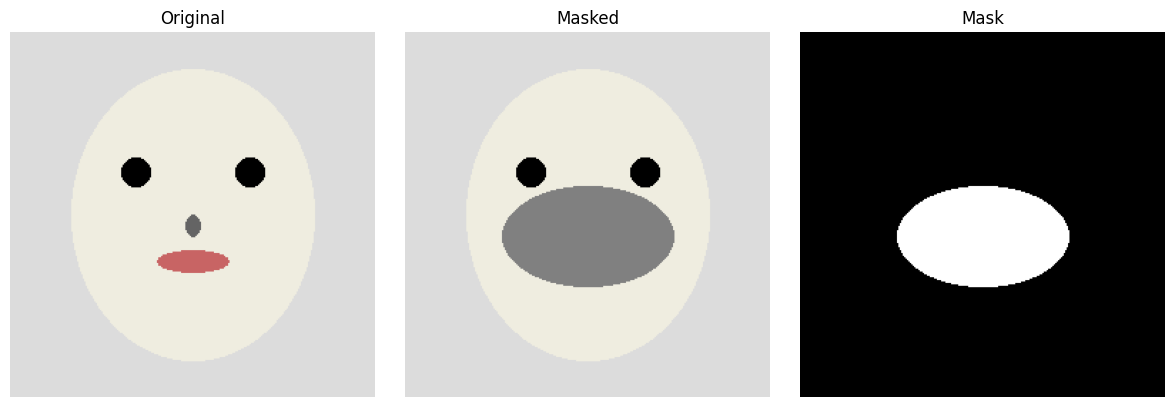

2. Model Architecture Test
N3D Model Test:
  Input: torch.Size([2, 3, 256, 256])
  Predicted mask: torch.Size([2, 1, 256, 256])
  Predicted coeffs: torch.Size([2, 237])
  Rendered 3D: torch.Size([2, 3, 256, 256])
Generator Test:
  Input (noisy): torch.Size([2, 3, 256, 256])
  Input (mask): torch.Size([2, 256, 256])
  Input (3D): torch.Size([2, 3, 256, 256])
  Output: torch.Size([2, 3, 256, 256])
Discriminator Test:
  Real prediction: torch.Size([2, 1, 4, 4])
  Fake prediction: torch.Size([2, 1, 4, 4])

3. Training Phase
Start training? (y/n): y

Phase 1: Training N3D module...
Starting N3D training phase...
N3D Step 0/5000, Total Loss: 1.9391
  BCE: 0.7263, Coef: 0.8115, Photo: 0.3879, ID: 0.1332
N3D Step 1000/5000, Total Loss: 1.1928
  BCE: 0.0134, Coef: 0.7958, Photo: 0.3710, ID: 0.1263
N3D Step 2000/5000, Total Loss: 1.2036
  BCE: 0.0113, Coef: 0.8102, Photo: 0.3688, ID: 0.1332
Learning rate reduced to 1e-5
N3D Step 3000/5000, Total Loss: 1.1878
  BCE: 0.0113, Coef: 0.7945, Photo: 0

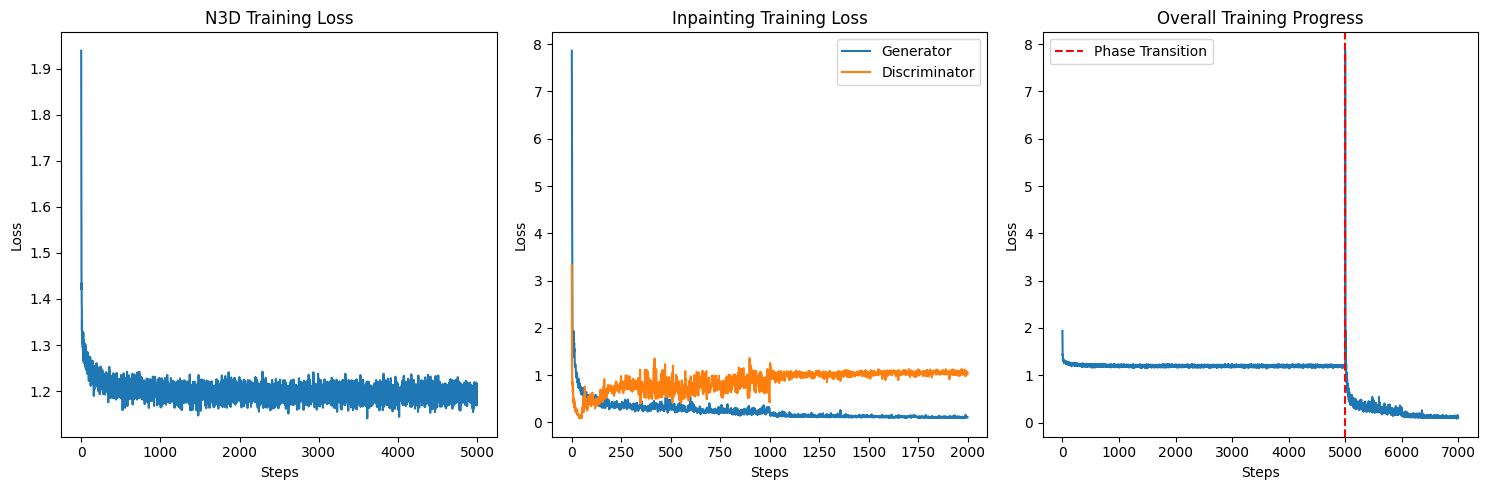


4. Evaluation
Evaluating model...
Batch 0: L1=0.0091, PSNR=43.04, SSIM=0.9822


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:02<00:00, 34.7MB/s]
100%|██████████| 5/5 [00:00<00:00, 16.59it/s]


Evaluation Results:
  L1 Loss: 0.0092
  PSNR: 42.82 dB
  SSIM: 0.9793
  FID Score: 54.16

Visualizing results...


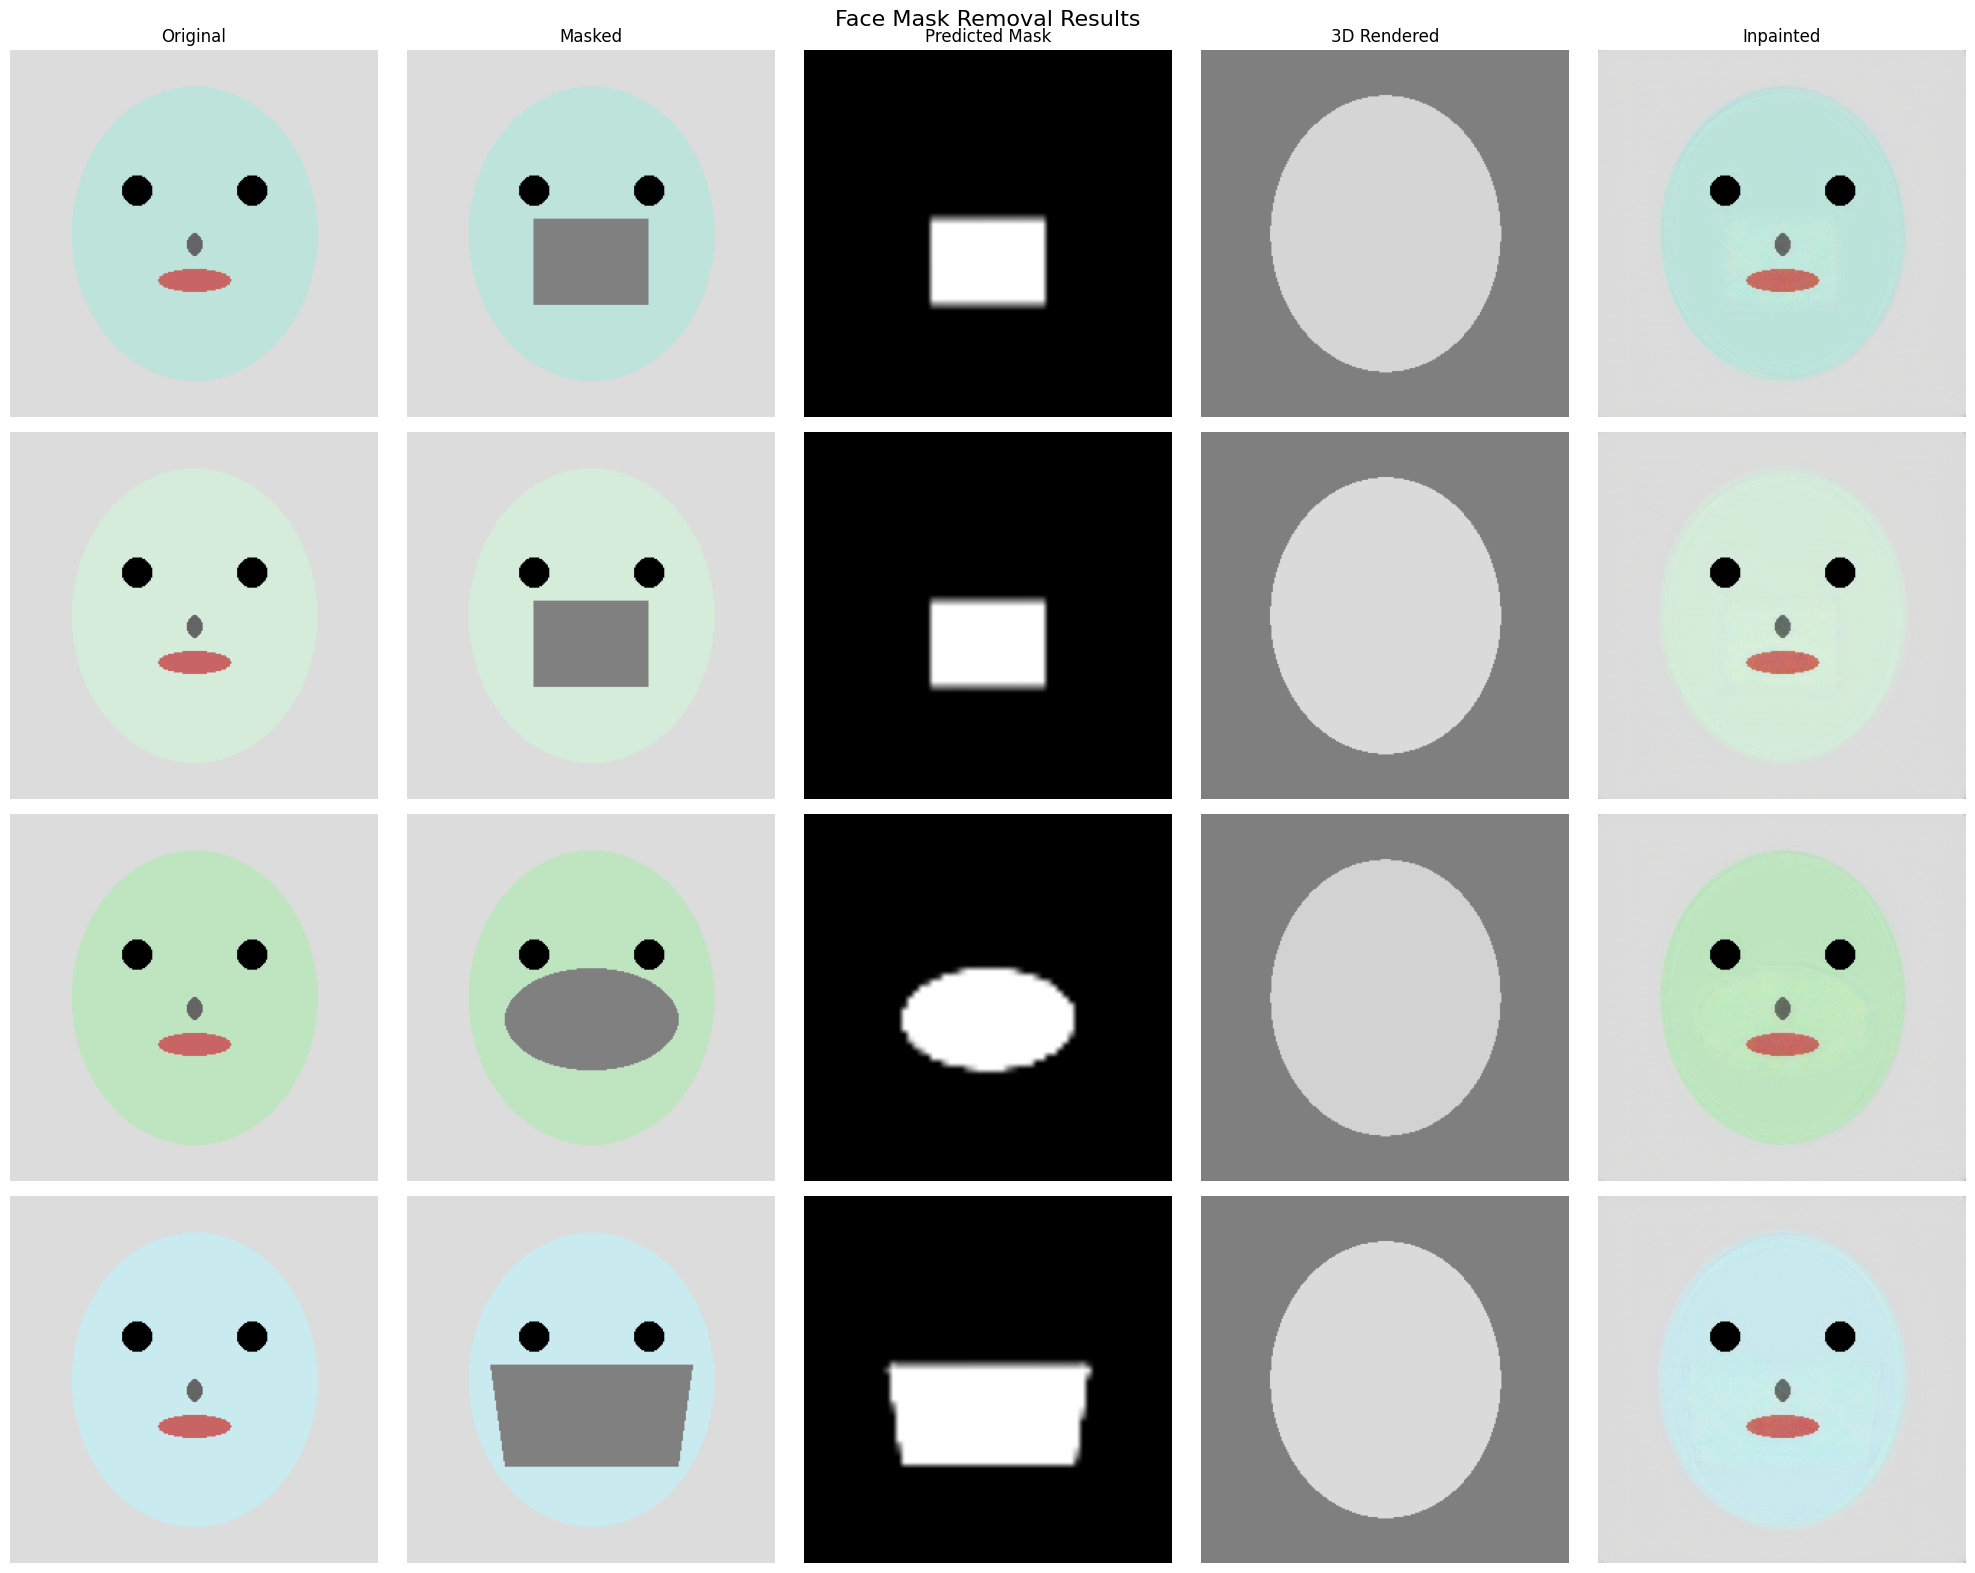


Saving final models...
Final models saved to: /content/drive/MyDrive/check_point_face_mask_removal_3d_prior
Training and evaluation completed successfully!


In [ ]:
def main():
    checkpoint_dir = "/content/drive/MyDrive/check_point_face_mask_removal_3d_prior"
    os.makedirs(checkpoint_dir, exist_ok=True)

    print("=" * 50)
    print("1. Dataset Verification")
    print("=" * 50)

    sample_batch = next(iter(train_loader))
    print(f"Batch shapes:")
    print(f"  Original: {sample_batch['original'].shape}")
    print(f"  Masked: {sample_batch['masked'].shape}")
    print(f"  Mask: {sample_batch['mask'].shape}")

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    original_sample = tensor_to_numpy(sample_batch['original'][0])
    masked_sample = tensor_to_numpy(sample_batch['masked'][0])
    mask_sample = sample_batch['mask'][0].numpy()

    axes[0].imshow(original_sample)
    axes[0].set_title('Original')
    axes[0].axis('off')

    axes[1].imshow(masked_sample)
    axes[1].set_title('Masked')
    axes[1].axis('off')

    axes[2].imshow(mask_sample, cmap='gray')
    axes[2].set_title('Mask')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    print("=" * 50)
    print("2. Model Architecture Test")
    print("=" * 50)

    with torch.no_grad():
        test_input = sample_batch['masked'][:2].to(device)
        pred_mask, pred_coeffs = n3d_model(test_input)
        rendered_3d = simple_3d_render(pred_coeffs, img_size=256)

        print(f"N3D Model Test:")
        print(f"  Input: {test_input.shape}")
        print(f"  Predicted mask: {pred_mask.shape}")
        print(f"  Predicted coeffs: {pred_coeffs.shape}")
        print(f"  Rendered 3D: {rendered_3d.shape}")

    with torch.no_grad():
        noisy_input = add_noise_to_masked_region(test_input, pred_mask.squeeze(1))
        fake_output = generator(noisy_input, pred_mask.squeeze(1), rendered_3d)

        print(f"Generator Test:")
        print(f"  Input (noisy): {noisy_input.shape}")
        print(f"  Input (mask): {pred_mask.squeeze(1).shape}")
        print(f"  Input (3D): {rendered_3d.shape}")
        print(f"  Output: {fake_output.shape}")

    with torch.no_grad():
        real_pred = discriminator(sample_batch['original'][:2].to(device))
        fake_pred = discriminator(fake_output)

        print(f"Discriminator Test:")
        print(f"  Real prediction: {real_pred.shape}")
        print(f"  Fake prediction: {fake_pred.shape}")

    print("\n" + "=" * 50)
    print("3. Training Phase")
    print("=" * 50)

    start_training = input("Start training? (y/n): ").lower().strip()

    if start_training == 'y':
        print("\nPhase 1: Training N3D module...")

        n3d_steps = 5000
        n3d_losses = train_n3d_phase(
            n3d_model, train_loader, optimizer_n3d, loss_fn, arcface,
            num_steps=n3d_steps, save_interval=500
        )

        print("\nPhase 2: Training Inpainting module...")

        inpainting_steps = 2000
        g_losses, d_losses = train_inpainting_phase(
            n3d_model, generator, discriminator, train_loader,
            optimizer_g, optimizer_d, loss_fn, arcface,
            num_steps=inpainting_steps, save_interval=500
        )

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.plot(n3d_losses)
        plt.title('N3D Training Loss')
        plt.xlabel('Steps')
        plt.ylabel('Loss')

        plt.subplot(1, 3, 2)
        plt.plot(g_losses, label='Generator')
        plt.plot(d_losses, label='Discriminator')
        plt.title('Inpainting Training Loss')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 3, 3)
        combined_steps = list(range(len(n3d_losses))) + list(range(len(n3d_losses), len(n3d_losses) + len(g_losses)))
        combined_losses = n3d_losses + g_losses
        plt.plot(combined_steps, combined_losses)
        plt.title('Overall Training Progress')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.axvline(x=len(n3d_losses), color='r', linestyle='--', label='Phase Transition')
        plt.legend()

        plt.tight_layout()
        plt.show()

        print("\n" + "=" * 50)
        print("4. Evaluation")
        print("=" * 50)

        results = evaluate_model(n3d_model, generator, test_loader, arcface, num_batches=5)

        print("Evaluation Results:")
        print(f"  L1 Loss: {results['L1_Loss']:.4f}")
        print(f"  PSNR: {results['PSNR']:.2f} dB")
        print(f"  SSIM: {results['SSIM']:.4f}")
        print(f"  FID Score: {results['FID']:.2f}")

        print("\nVisualizing results...")
        visualize_results(n3d_model, generator, test_loader, num_samples=4)

        print("\nSaving final models...")
        final_n3d_path = os.path.join(checkpoint_dir, 'final_n3d_model.pth')
        final_gen_path = os.path.join(checkpoint_dir, 'final_generator.pth')
        final_disc_path = os.path.join(checkpoint_dir, 'final_discriminator.pth')

        torch.save(n3d_model.state_dict(), final_n3d_path)
        torch.save(generator.state_dict(), final_gen_path)
        torch.save(discriminator.state_dict(), final_disc_path)

        print(f"Final models saved to: {checkpoint_dir}")
        print("Training and evaluation completed successfully!")

    else:
        print("Training skipped. Models are ready for testing.")
        print("You can now:")
        print("1. Load pre-trained weights if available")
        print("2. Run evaluation: evaluate_model(n3d_model, generator, test_loader, arcface)")
        print("3. Visualize results: visualize_results(n3d_model, generator, test_loader)")

main()